# Federated Learning using PyTorch and Flower

This tutorial will show how to leverage PyTorch to federate the training of a convolutional neural network over multiple clients using [Flower](https://flower.dev/). More specifically, we will use a ResNet model for the CIFAR10 dataset. The end goal is to classify 10 different objects in small images. 

In [19]:
!pip install -q flwr["simulation"] torch torchvision matplotlib numpy

You should consider upgrading via the '/home/w.lindskog/.pyenv/versions/3.9.5/bin/python3.9 -m pip install --upgrade pip' command.


We can now import the relevant modules.

In [20]:
from collections import OrderedDict
from typing import Callable, Dict, List, Optional, Tuple, Union
import os
import random
import warnings

import flwr as fl
import torch
import torchvision
from torchvision import transforms

from torch.utils.data import DataLoader

from matplotlib import pyplot as plt
import numpy as np

Next we will set some global variables and disable some of the logging to clear out our output.

In [21]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter('ignore')

DEVICE = torch.device("cpu")
NUM_CLIENTS = 2
NUM_ROUNDS = 5

Next, we'll create a function that fetches the data from torchvision. 

In [22]:
def load_data() -> Union[DataLoader, DataLoader]:
    """ Load data CIFAR10 from torchvision.datasets """
    # Set transform
    transform = transforms.Compose(
        [
            # cifar10 optimal transform
            transforms.Resize(32),
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.49139968, 0.48215841, 0.44653091],
                std=[0.24703223, 0.24348513, 0.26158784],
            ),
        ]
    )

    train_dataset = torchvision.datasets.CIFAR10(
        root="~/torch_datasets", train=True, transform=transform, download=True
    )
    test_dataset = torchvision.datasets.CIFAR10(
        root="~/torch_datasets", train=False, transform=transform, download=True
    )

    # Set to data loader
    # load 10% randomly sampled training and test dataset
    train_dataset = torch.utils.data.Subset(train_dataset, random.sample(range(len(train_dataset)), int(0.1 * len(train_dataset))))
    test_dataset = torch.utils.data.Subset(test_dataset, random.sample(range(len(test_dataset)), int(0.1 * len(test_dataset))))
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True
    )

    return train_loader, test_loader

Next, we get a pretrained resNet model. 

In [23]:
# Get simple MLP model
def get_model() -> torch.nn.Module:
    """ Get ResNet18 model """
    # simple mlp model for cifar10
    class MLP(torch.nn.Module):
        def __init__(self):
            super().__init__()
            self.flatten = torch.nn.Flatten()
            self.linear_relu_stack = torch.nn.Sequential(
                torch.nn.Linear(32 * 32 * 3, 512),
                torch.nn.ReLU(),
                torch.nn.Linear(512, 512),
                torch.nn.ReLU(),
                torch.nn.Linear(512, 10),
                torch.nn.ReLU(),
            )

        def forward(self, x):
            x = self.flatten(x)
            logits = self.linear_relu_stack(x)
            return logits
        
    return MLP()

In [24]:
def train(net, trainloader, epochs):
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=5e-4)
    net.train()
    for _ in range(epochs):
        for inputs, targets in trainloader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = net(inputs)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()


def test(net, testloader):
    loss_fn = torch.nn.CrossEntropyLoss()
    loss = 0
    net.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = net(inputs)
            loss += loss_fn(outputs, targets).item()
            predictions = torch.argmax(outputs, dim=-1)
            total += targets.size(0)
            correct += (predictions == targets).sum().item()
    accuracy = correct / total
    loss /= len(testloader.dataset)
    return loss, accuracy

In [25]:
class CIFAR10Client(fl.client.NumPyClient):
    def __init__(self,):
        self.net = get_model().to(DEVICE)
        self.trainloader, self.testloader = load_data()

    def get_parameters(self, config):
        return [val.cpu().numpy() for _, val in self.net.state_dict().items()]

    def set_parameters(self, parameters):
        params_dict = zip(self.net.state_dict().keys(), parameters)
        state_dict = OrderedDict(
            {
                k: torch.Tensor(v) if v.shape != torch.Size([]) else torch.Tensor([0])
                for k, v in params_dict
            }
        )
        print("-------------- State dict ------------------: ", state_dict)
        self.net.load_state_dict(state_dict, strict=True)

    def fit(self, parameters, config):
        self.set_parameters(parameters)
        print("Training Started...")
        train(self.net, self.trainloader, epochs=1)
        print("Training Finished.")
        return self.get_parameters(config={}), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        self.set_parameters(parameters)
        loss, accuracy = test(self.net, self.testloader)
        return float(loss), len(self.testloader), {"accuracy": float(accuracy), "loss": float(loss)}

In [26]:
def client_fn(cid):
  return CIFAR10Client()

In [27]:
def weighted_average(metrics):
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    losses = [num_examples * m["loss"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]
    print("accuracy: ", sum(accuracies) / sum(examples))
    return {"accuracy": sum(accuracies) / sum(examples), "loss": sum(losses) / sum(examples)}

strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,
    fraction_evaluate=1.0,
    evaluate_metrics_aggregation_fn=weighted_average,
)

hist = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_ROUNDS),
    strategy=strategy,
    client_resources={"num_cpus": 1, "num_gpus": 1},
    ray_init_args={"log_to_driver": False, "num_cpus": 1, "num_gpus": 1}
)

INFO flwr 2023-11-06 17:58:29,164 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-11-06 17:58:32,220	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-11-06 17:58:32,476 | app.py:210 | Flower VCE: Ray initialized with resources: {'CPU': 1.0, 'node:__internal_head__': 1.0, 'memory': 17110081536.0, 'accelerator_type:G': 1.0, 'GPU': 1.0, 'object_store_memory': 8555040768.0, 'node:172.20.106.81': 1.0}
INFO flwr 2023-11-06 17:58:32,476 | app.py:224 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 1}
INFO flwr 2023-11-06 17:58:32,481 | app.py:270 | Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO flwr 2023-11-06 17:58:32,481 | server.py:89 | Initializing global parameters
INFO flwr 2023-11-06 17:58:32,482 | server.py:276 | Requesting initial parameters from one random client
INFO flwr 2023-11-06 17:58:34,322 | server.py:280 | Received 

accuracy:  0.195


DEBUG flwr 2023-11-06 17:58:43,930 | server.py:236 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-11-06 17:58:43,938 | server.py:173 | evaluate_round 2: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-11-06 17:58:45,715 | server.py:187 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-11-06 17:58:45,716 | server.py:222 | fit_round 3: strategy sampled 2 clients (out of 2)


accuracy:  0.286


DEBUG flwr 2023-11-06 17:58:49,273 | server.py:236 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-11-06 17:58:49,279 | server.py:173 | evaluate_round 3: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-11-06 17:58:51,044 | server.py:187 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-11-06 17:58:51,045 | server.py:222 | fit_round 4: strategy sampled 2 clients (out of 2)


accuracy:  0.3155


DEBUG flwr 2023-11-06 17:58:54,636 | server.py:236 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-11-06 17:58:54,644 | server.py:173 | evaluate_round 4: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-11-06 17:58:56,391 | server.py:187 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-11-06 17:58:56,391 | server.py:222 | fit_round 5: strategy sampled 2 clients (out of 2)


accuracy:  0.348


DEBUG flwr 2023-11-06 17:58:59,971 | server.py:236 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-11-06 17:58:59,977 | server.py:173 | evaluate_round 5: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-11-06 17:59:01,732 | server.py:187 | evaluate_round 5 received 2 results and 0 failures
INFO flwr 2023-11-06 17:59:01,732 | server.py:153 | FL finished in 27.409336004999204
INFO flwr 2023-11-06 17:59:01,733 | app.py:225 | app_fit: losses_distributed [(1, 0.07227551662921905), (2, 0.06751345759630203), (3, 0.06369143313169479), (4, 0.06263480401039123), (5, 0.06235747754573823)]
INFO flwr 2023-11-06 17:59:01,733 | app.py:226 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-11-06 17:59:01,734 | app.py:227 | app_fit: metrics_distributed {'accuracy': [(1, 0.195), (2, 0.286), (3, 0.3155), (4, 0.348), (5, 0.328)], 'loss': [(1, 0.07227551662921905), (2, 0.06751345759630203), (3, 0.06369143313169479), (4, 0.06263480401039123), (5, 0.06235747754573823)]}
INFO flwr 2023-

accuracy:  0.328


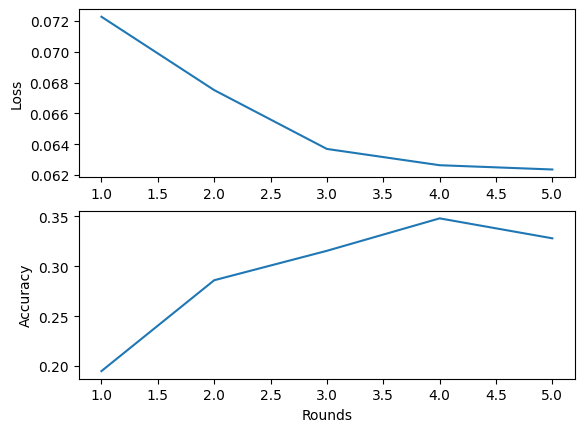

In [28]:
metric_type = "distributed"
metric_dict = (
    hist.metrics_centralized
    if metric_type == "centralized"
    else hist.metrics_distributed
)
_, values = zip(*metric_dict["accuracy"])

# let's extract decentralized loss (main metric reported in FedProx paper)
rounds_loss, values_loss = zip(*hist.losses_distributed)

_, axs = plt.subplots(nrows=2, ncols=1, sharex="row")
axs[0].plot(np.asarray(rounds_loss), np.asarray(values_loss))
axs[1].plot(np.asarray(rounds_loss), np.asarray(values))

axs[0].set_ylabel("Loss")
axs[1].set_ylabel("Accuracy")

# plt.title(f"{metric_type.capitalize()} Validation - MNIST")
plt.xlabel("Rounds")
# plt.legend(loc="lower right")

plt.show()